In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
path = "/content/Netflix Dataset 1.csv"    # adjust if needed
df = pd.read_csv(path)

In [3]:
df.head()

,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
df.columns = [c.strip() for c in df.columns]

print("Shape:", df.shape)
print(df.columns.tolist())

Shape: (7789, 11)
['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']


In [5]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Show_Id            0
Category           0
Title              0
Director        2388
Cast             718
Country          507
Release_Date      10
Rating             7
Duration           0
Type               0
Description        0
dtype: int64


**2. DATA CLEANING & FEATURE ENGINEERING**  

In [6]:
# Create release_year
df['release_year'] = pd.to_numeric(
    df['Release_Date'].astype(str).str.extract(r'(\d{4})')[0],
    errors='coerce'
).astype('Int64')

In [7]:
# Extract duration minutes
def extract_minutes(x):
    s = str(x)
    if 'min' in s:
        try: return int(s.split('min')[0].strip())
        except: return np.nan
    return np.nan
df['duration_minutes'] = df['Duration'].apply(extract_minutes)

In [8]:
# Number of actors and countries
df['num_actors'] = df['Cast'].fillna('').apply(lambda s: len([x for x in s.split(',') if x.strip()!='']))
df['num_countries'] = df['Country'].fillna('').apply(lambda s: len([x for x in s.split(',') if x.strip()!='']))
df['is_series'] = df['Category'].str.lower().str.contains('tv')

In [9]:
# Convert Release_Date to datetime
df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce')

In [10]:
# Extract Year
df['Year'] = df['Release_Date'].dt.year

In [11]:
# Handle missing
df['Director'] = df['Director'].fillna('Unknown')
df['Country'] = df['Country'].fillna('Unknown')
df['Rating'] = df['Rating'].fillna('Unknown')
df['Cast'] = df['Cast'].fillna("Unknown")

**3. BASIC DATA EXPLORATION**

In [12]:
# Dataset span in years
print("\nDataset covers years from", df['Year'].min(), "to", df['Year'].max())


Dataset covers years from 2008.0 to 2021.0


In [13]:
# Count of Movies vs TV Shows
print("\nCategory Distribution:\n", df['Category'].value_counts())



Category Distribution:
 Category
Movie      5379
TV Show    2410
Name: count, dtype: int64


In [14]:
# Top Countries
print("\nTop 5 Countries:\n", df['Country'].value_counts().head(5))


Top 5 Countries:
 Country
United States     2556
India              923
Unknown            507
United Kingdom     397
Japan              226
Name: count, dtype: int64


In [15]:
print("\nTop Ratings:")
print(df['Rating'].value_counts().head(10))


Top Ratings:
Rating
TV-MA    2865
TV-14    1931
TV-PG     806
R         665
PG-13     386
TV-Y      280
TV-Y7     271
PG        247
TV-G      194
NR         84
Name: count, dtype: int64


In [17]:
print("\nTop Countries:")
print(df['Country'].value_counts().head(10))


Top Countries:
Country
United States     2556
India              923
Unknown            507
United Kingdom     397
Japan              226
South Korea        183
Canada             177
Spain              134
France             115
Egypt              101
Name: count, dtype: int64


In [18]:
print("\nTop Directors:")
print(df['Director'].value_counts().head(10))


Top Directors:
Director
Unknown                   2388
Raúl Campos, Jan Suter      18
Marcus Raboy                16
Jay Karas                   14
Cathy Garcia-Molina         13
Jay Chapman                 12
Youssef Chahine             12
Martin Scorsese             12
Steven Spielberg            10
David Dhawan                 9
Name: count, dtype: int64


**4. VISUAL EXPLORATION**

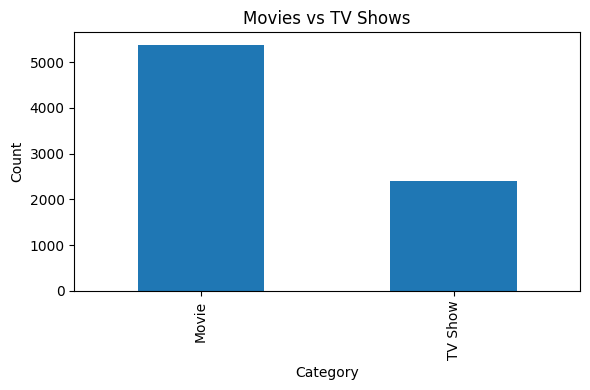

In [19]:
plt.figure(figsize=(6,4))
df['Category'].value_counts().plot(kind='bar')
plt.title("Movies vs TV Shows")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

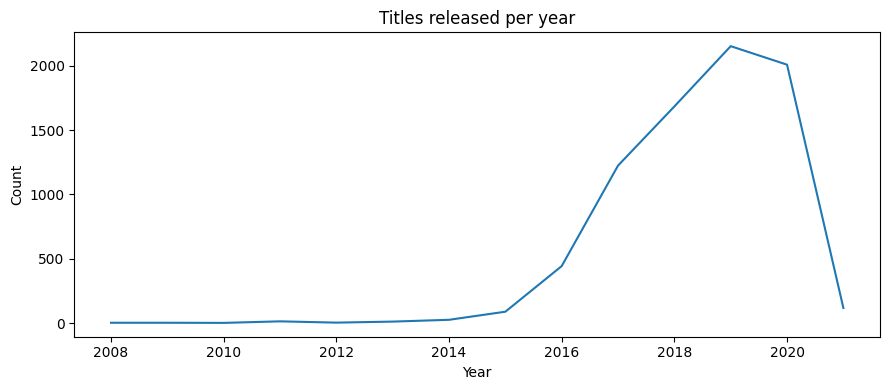

In [20]:
# Titles per release year
plt.figure(figsize=(9,4))
df.groupby('release_year').size().plot()
plt.title("Titles released per year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

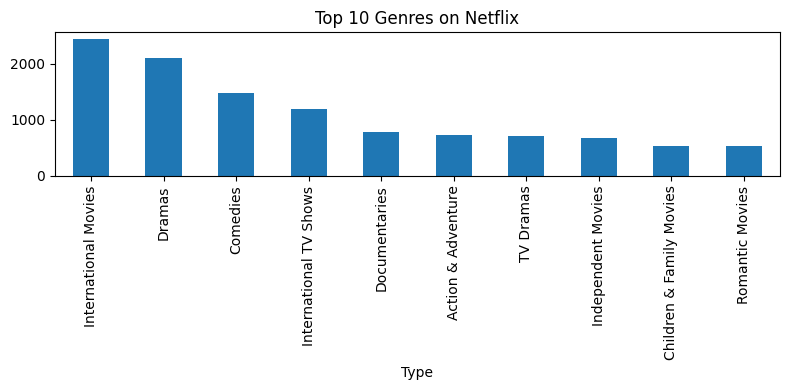

In [21]:
# Top 10 genres (using Type as genre descriptor)
genres = df['Type'].dropna().str.split(',').explode().str.strip()
top_genres = genres.value_counts().head(10)
plt.figure(figsize=(8,4))
top_genres.plot(kind='bar')
plt.title("Top 10 Genres on Netflix")
plt.tight_layout()
plt.show()

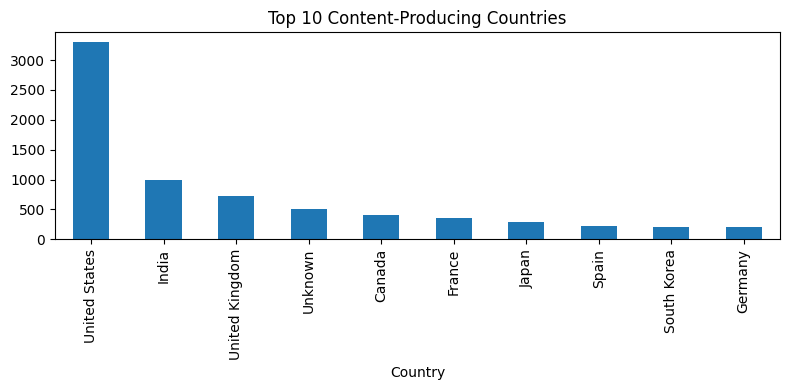

In [22]:
# Top countries
countries = df['Country'].dropna().str.split(',').explode().str.strip()
top_countries = countries.value_counts().head(10)
plt.figure(figsize=(8,4))
top_countries.plot(kind='bar')
plt.title("Top 10 Content-Producing Countries")
plt.tight_layout()
plt.show()

**5. ACTORS & DIRECTORS ANALYSIS**

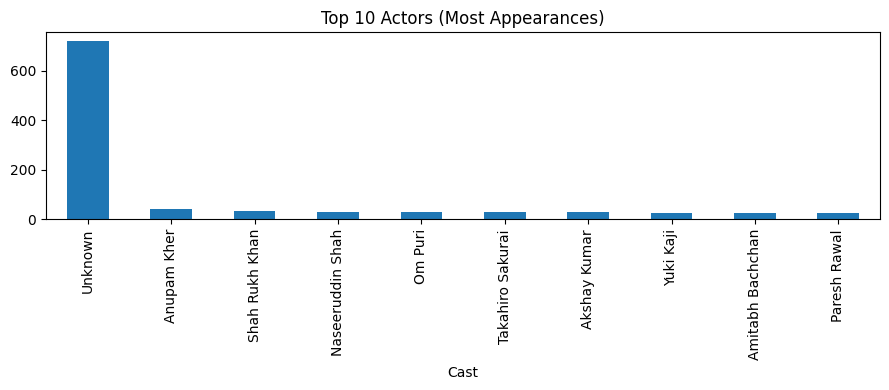

In [24]:
actors = df['Cast'].dropna().str.split(',').explode().str.strip()
top_actors = actors.value_counts().head(10)
plt.figure(figsize=(9,4))
top_actors.plot(kind='bar')
plt.title("Top 10 Actors (Most Appearances)")
plt.tight_layout()
plt.show()

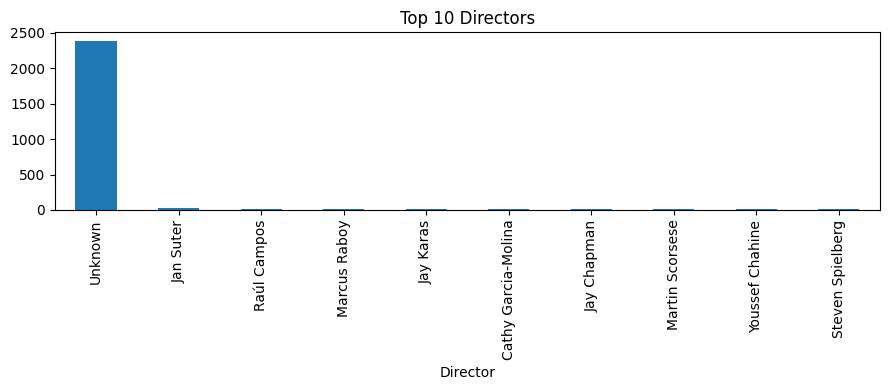

In [25]:
directors = df['Director'].dropna().str.split(',').explode().str.strip()
top_directors = directors.value_counts().head(10)
plt.figure(figsize=(9,4))
top_directors.plot(kind='bar')
plt.title("Top 10 Directors")
plt.tight_layout()
plt.show()

**6. TIME TRENDS BY GENRE**

In [26]:
df_genres = df[['Title','release_year','Type']].dropna()
df_genres = df_genres.assign(genre=df_genres['Type'].str.split(',')).explode('genre')
df_genres['genre'] = df_genres['genre'].str.strip()

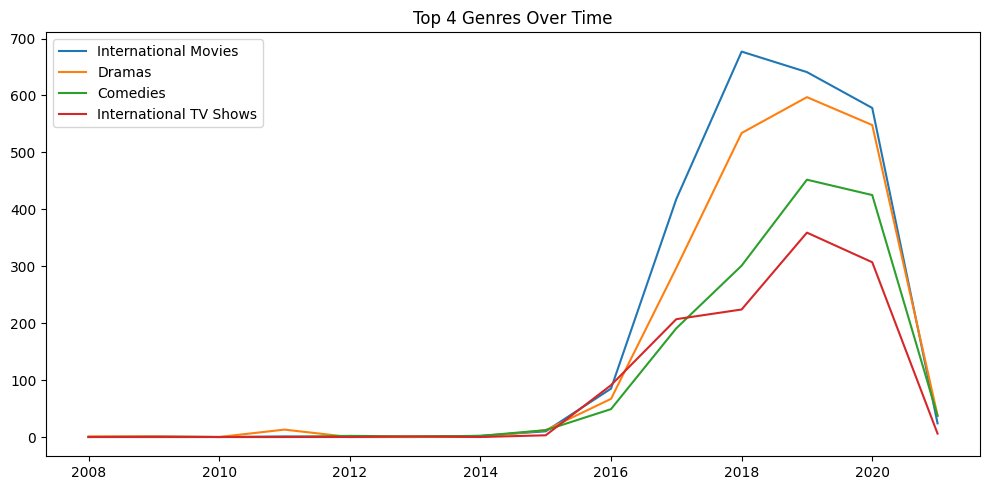

In [27]:
pivot = df_genres.pivot_table(index='release_year', columns='genre',
                              values='Title', aggfunc='count', fill_value=0)
top4 = df_genres['genre'].value_counts().head(4).index
plt.figure(figsize=(10,5))
for g in top4:
    plt.plot(pivot.index, pivot[g], label=g)
plt.legend()
plt.title("Top 4 Genres Over Time")
plt.tight_layout()
plt.show()

**7. SIMPLE CONTENT-BASED RECOMMENDER**

In [28]:
df['desc'] = df['Description'].fillna('')
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['desc'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(df.index, index=df['Title'].str.lower())

In [29]:
def recommend(title, topn=10):
    title_low = title.lower()
    if title_low not in indices:
        print("Title not found.")
        return pd.DataFrame()
    idx = indices[title_low]
    sims = list(enumerate(cosine_sim[idx]))
    sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:topn+1]
    recs = df.iloc[[i[0] for i in sims]][['Title','Category','Type','Country','Rating','release_year']]
    return recs

## **Example usage:**
It takes a title name (e.g., "Narcos") and finds other shows or movies on Netflix in your dataset that have similar descriptions (using a text-based similarity model built from the Description column).

In [30]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
print("\nRecommendations for 'Narcos':")
try:
    recs = recommend("Narcos", topn=10)
    from IPython.display import display
    display(recs)
    print("\nClean table view:")
    print(recs.to_string(index=False))
except Exception as e:
    print("Recommender error:", e)


Recommendations for 'Narcos':


,Title,Category,Type,Country,Rating,release_year
4402,Narcos: Mexico,TV Show,"Crime TV Shows, TV Action & Adventure, TV Dramas","Mexico, United States",TV-MA,2020
1948,El Chapo,TV Show,"Crime TV Shows, Spanish-Language TV Shows, TV ...","Mexico, United States",TV-MA,2018
5842,Street Flow,Movie,"Dramas, International Movies",France,TV-MA,2019
1441,Cocaine,TV Show,"British TV Shows, Crime TV Shows, Docuseries",United Kingdom,TV-14,2016
1947,El Cartel 2,TV Show,"Crime TV Shows, International TV Shows, Spanis...",Colombia,TV-MA,2018
685,Bad Blood,TV Show,"Crime TV Shows, TV Dramas",Canada,TV-MA,2019
6880,The Sky Is Pink,Movie,"Dramas, International Movies","India, United Kingdom, Canada, United States",TV-MA,2019
5079,Raja Natwarlal,Movie,"Dramas, International Movies, Thrillers",India,TV-14,2018
2749,Historia de un clan,TV Show,"Crime TV Shows, International TV Shows, Spanis...",Argentina,TV-MA,2017
2075,"Extremely Wicked, Shockingly Evil and Vile",Movie,"Dramas, Independent Movies",United States,R,2019



Clean table view:
                                     Title Category                                                              Type                                      Country Rating  release_year
                            Narcos: Mexico  TV Show                  Crime TV Shows, TV Action & Adventure, TV Dramas                        Mexico, United States  TV-MA          2020
                                  El Chapo  TV Show  Crime TV Shows, Spanish-Language TV Shows, TV Action & Adventure                        Mexico, United States  TV-MA          2018
                               Street Flow    Movie                                      Dramas, International Movies                                       France  TV-MA          2019
                                   Cocaine  TV Show                      British TV Shows, Crime TV Shows, Docuseries                               United Kingdom  TV-14          2016
                               El Cartel 2  TV Show Crime TV 